In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'

# Read Data

In [2]:
def file_reader(basedir, filename):
    if filename.endswith('.csv'):
        try:
            df = pd.read_csv(basedir + filename, header=15)
        except:
            df = pd.read_csv(basedir + filename, encoding='euc-kr', header=15)
    elif filename.endswith('.xlsx'):
        try:
            df = pd.read_excel(basedir + filename, header=16)
        except:
            df = pd.read_excel(basedir + filename, encoding='euc-kr', header=16)
    else:
        print('error')
    
    return df

In [3]:
def read_real_estate_prices_df():
    basedir = './국토교통부_실거래가_공개시스템/'
    filenames = os.listdir(basedir)
    
    apart_trade_files = [filename for filename in filenames if filename.startswith('아파트(매매)')]
    apart_lease_files = [filename for filename in filenames if filename.startswith('아파트(전월세)')]
    multiplex_trade_files = [filename for filename in filenames if filename.startswith('연립다세대(매매)')]
    multiplex_lease_files = [filename for filename in filenames if filename.startswith('연립다세대(전월세)')]
    officetel_trade_files = [filename for filename in filenames if filename.startswith('오피스텔(매매)')]
    officetel_lease_files = [filename for filename in filenames if filename.startswith('오피스텔(전월세)')]
    
    #
    apart_trade_dfs_list = []
    for filename in apart_trade_files:
        df = file_reader(basedir, filename)
        apart_trade_dfs_list.append(df)
    apart_trade_df = pd.concat(apart_trade_dfs_list).reset_index(drop=True)
    
    #
    apart_lease_dfs_list = []
    for filename in apart_lease_files:
        df = file_reader(basedir, filename)
        apart_lease_dfs_list.append(df)
    apart_lease_df = pd.concat(apart_lease_dfs_list).reset_index(drop=True)
    
    #
    multiplex_trade_dfs_list = []
    for filename in multiplex_trade_files:
        df = file_reader(basedir, filename)
        multiplex_trade_dfs_list.append(df)
    multiplex_trade_df = pd.concat(multiplex_trade_dfs_list).reset_index(drop=True)
    
    #
    multiplex_lease_dfs_list = []
    for filename in multiplex_lease_files:
        df = file_reader(basedir, filename)
        multiplex_lease_dfs_list.append(df)
    multiplex_lease_df = pd.concat(multiplex_lease_dfs_list).reset_index(drop=True)
    
    #
    officetel_trade_dfs_list = []
    for filename in officetel_trade_files:
        df = file_reader(basedir, filename)
        officetel_trade_dfs_list.append(df)
    officetel_trade_df = pd.concat(officetel_trade_dfs_list).reset_index(drop=True)
    
    #
    officetel_lease_dfs_list = []
    for filename in officetel_lease_files:
        df = file_reader(basedir, filename)
        officetel_lease_dfs_list.append(df)
    officetel_lease_df = pd.concat(officetel_lease_dfs_list).reset_index(drop=True)
    
    
    return apart_trade_df, apart_lease_df, multiplex_trade_df, multiplex_lease_df, officetel_trade_df, officetel_lease_df

In [4]:
%%time
apart_trade_df, apart_lease_df, multiplex_trade_df, multiplex_lease_df, officetel_trade_df, officetel_lease_df\
= read_real_estate_prices_df()

C:\Users\나\AppData\Roaming\Python\Python37\site-packages\IPython\core\magics\execution.py:1321: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


Wall time: 4min 35s


# From EDA & Preprocessing 1

In [5]:
apart_lease_df.drop(apart_lease_df[apart_lease_df['전용면적(㎡)'].isna()].index, inplace=True)

In [6]:
# 전용면적과 층 null들을 median 값으로 교체 시 사용

def area_floor_fillna_median(df):
    df = df.copy()
    
    df['temp_full_addr'] = df['시군구'].str.split(' ').apply(lambda x: x[0]) + ' ' + df['시군구'].str.split(' ').apply(lambda x: x[1])\
                           + ' ' + df['도로명'] + ' ' + df['단지명']
    
    area_null_df = df[df['전용면적(㎡)'].isna()]
    
    unique_addresses = area_null_df['temp_full_addr'].unique()
    
    for address in unique_addresses:
        addr_df = df[df['temp_full_addr'] == address]
        
        area_median = addr_df['전용면적(㎡)'].median()
        
        df.loc[addr_df[addr_df['전용면적(㎡)'].isna()].index, '전용면적(㎡)'] = area_median
        
    df = df.drop(df[df['전용면적(㎡)'].isna()].index)
        
        
    floor_null_df = df[df['층'].isna()]
    
    unique_addresses = floor_null_df['temp_full_addr'].unique()
    
    for address in unique_addresses:
        addr_df = df[df['temp_full_addr'] == address]
        
        floor_median = addr_df['층'].median()
        
        df.loc[addr_df[addr_df['층'].isna()].index, '층'] = floor_median
        
    df = df.drop(df[df['층'].isna()].index)
        
    return df

In [7]:
multiplex_trade_df.loc[multiplex_trade_df[multiplex_trade_df['건축년도'].isna()].index, '건축년도'] = 1971
multiplex_lease_df.drop(multiplex_lease_df[multiplex_lease_df['층'].isna()].index, inplace=True)

In [8]:
# 모든 df 도로명 빈 칸 null 로 교체

def replace_empty_to_null(df):
    df = df.copy()
    
    empty_df = df[df['도로명'] == ' ']
    
    df.loc[empty_df.index, '도로명'] = np.nan
    
    return df

In [9]:
apart_trade_df = replace_empty_to_null(apart_trade_df)
apart_lease_df = replace_empty_to_null(apart_lease_df)
multiplex_trade_df = replace_empty_to_null(multiplex_trade_df)
multiplex_lease_df = replace_empty_to_null(multiplex_lease_df)
officetel_trade_df = replace_empty_to_null(officetel_trade_df)
officetel_lease_df = replace_empty_to_null(officetel_lease_df)

In [10]:
multiplex_lease_df.loc[multiplex_lease_df[multiplex_lease_df['건축년도'].isna()].index, '건축년도'] = 1971

In [11]:
# 건축년도가 null 인 row 들에 있는 주소들 중에서, 같은 주소지만 건축년도 값이 있는 주소는 null 을 채워넣고, 없는 주소는 df 에서 제거.
# 추가적으로, 한 주소지, 단지이름에 건축년도가 두 가지 이상 있는지도 조사함.

def bltyear_fill_and_remove_null(df):
    df = df.copy()
    
    df['temp_full_addr'] = df['시군구'] + df['번지'] + df['단지명']
    
    bltyear_null_df = df[df['건축년도'].isna()]
    
    unique_addrs = bltyear_null_df['temp_full_addr'].unique()
    
    concat_list = []
    for addr in unique_addrs:
        addr_df = df[df['temp_full_addr'] == addr]
        if addr_df['건축년도'].isna().sum() != addr_df.shape[0]:
            if addr_df['건축년도'].std() != 0:
                print('건축년도가 두 가지 이상인 주소가 있음.')
            
            addr_df['건축년도'].fillna(addr_df['건축년도'].mean(), inplace=True)
            
            concat_list.append(addr_df)
    
    df.drop(columns=['temp_full_addr'], inplace=True)
    
    if len(concat_list) > 0:
        concat_df = pd.concat(concat_list)
    else:
        return df
    
    #return concat_df
    
    df.loc[concat_df.index, '건축년도'] = concat_df['건축년도']
    
    bltyear_null_df = df[df['건축년도'].isna()]
    
    df.drop(bltyear_null_df.index, inplace=True)
        
    return df.reset_index(drop=True)

In [12]:
officetel_trade_df = bltyear_fill_and_remove_null(officetel_trade_df)
officetel_lease_df = bltyear_fill_and_remove_null(officetel_lease_df)

In [13]:
def trade_dfs_change_dtype(df):
    df = df.copy()
    
    df['거래금액(만원)'] = df['거래금액(만원)'].apply(str)
    df['거래금액(만원)'] = pd.to_numeric(df['거래금액(만원)'].str.replace(',', ''))
    df['층'] = df['층'].astype('int')
    df['건축년도'] = df['건축년도'].astype('int')
    
    return df

In [14]:
apart_trade_df = trade_dfs_change_dtype(apart_trade_df)
multiplex_trade_df = trade_dfs_change_dtype(multiplex_trade_df)
officetel_trade_df = trade_dfs_change_dtype(officetel_trade_df)

In [15]:
def lease_dfs_change_dtype(df):
    df = df.copy()
    
    df['보증금(만원)'] = df['보증금(만원)'].apply(str)
    df['월세(만원)'] = df['월세(만원)'].apply(str)
    df['보증금(만원)'] = pd.to_numeric(df['보증금(만원)'].str.replace(',', ''))
    df['월세(만원)'] = pd.to_numeric(df['월세(만원)'].str.replace(',', ''))
    df['층'] = df['층'].astype('int')
    df['건축년도'] = df['건축년도'].astype('int')
    
    return df

In [16]:
apart_lease_df = lease_dfs_change_dtype(apart_lease_df)
multiplex_lease_df = lease_dfs_change_dtype(multiplex_lease_df)
officetel_lease_df = lease_dfs_change_dtype(officetel_lease_df)

# EDA & Preprocessing 2

## 금액 관련 조사

### 건물 종류별 거래 금액 분포 관련 조사

### 아파트

In [17]:
apart_trade_df['거래금액(만원)'].describe()

count    1.168192e+06
mean     5.231642e+04
std      4.018041e+04
min      3.500000e+02
25%      2.800000e+04
50%      4.130000e+04
75%      6.300000e+04
max      8.400000e+05
Name: 거래금액(만원), dtype: float64

<AxesSubplot:>

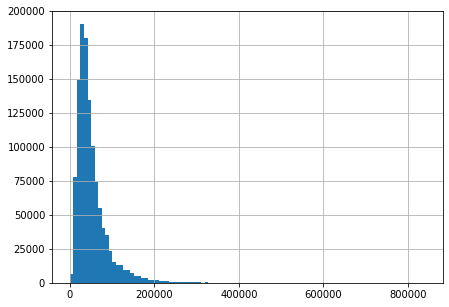

In [18]:
apart_trade_df['거래금액(만원)'].hist(bins=100, figsize=(7,5))

#### 거래 금액 대부분이 200,000 밑이며, 상위 75%가 6.3e+4인것을 감안했을 때, 최대값인 8.4e+5는 매우 큰 가격임. 이에 조사함.

In [19]:
max_df = apart_trade_df[apart_trade_df['거래금액(만원)'] == 840000]
print(max_df.shape)
max_df.head()

(1, 12)


,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명
518686,서울특별시 용산구 한남동,810,810,0,한남더힐,244.749,201901,10,840000,3,2011,독서당로 111


In [20]:
hannam_df = apart_trade_df[(apart_trade_df['단지명'] == '한남더힐') & (apart_trade_df['전용면적(㎡)'] > 240)]
print(hannam_df.shape)
hannam_df.head()

(93, 12)


,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명
145981,서울특별시 용산구 한남동,810,810,0,한남더힐,243.642,201402,25,656500,1,2011,독서당로 111
145996,서울특별시 용산구 한남동,810,810,0,한남더힐,243.201,201404,21,630000,1,2011,독서당로 111
146006,서울특별시 용산구 한남동,810,810,0,한남더힐,243.642,201404,21,630000,1,2011,독서당로 111
254202,서울특별시 용산구 한남동,810,810,0,한남더힐,244.783,201601,18,790000,3,2011,독서당로 111
254207,서울특별시 용산구 한남동,810,810,0,한남더힐,240.230,201602,5,624000,-2,2011,독서당로 111


In [21]:
hannam_df.tail()

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명
1157861,서울특별시 용산구 한남동,810,810,0,한남더힐,244.783,201507,28,770000,3,2011,독서당로 111
1157864,서울특별시 용산구 한남동,810,810,0,한남더힐,240.305,201508,13,615000,3,2011,독서당로 111
1157865,서울특별시 용산구 한남동,810,810,0,한남더힐,243.642,201509,7,690000,1,2011,독서당로 111
1157867,서울특별시 용산구 한남동,810,810,0,한남더힐,244.783,201510,28,750000,3,2011,독서당로 111
1157868,서울특별시 용산구 한남동,810,810,0,한남더힐,243.642,201511,12,719700,1,2011,독서당로 111


In [22]:
hannam810_df = apart_trade_df[(apart_trade_df['시군구'] == '서울특별시 용산구 한남동') & (apart_trade_df['본번'] == 810)]
hannam810_df.shape

(674, 12)

In [23]:
hannam810_df['거래금액(만원)'].describe()

count       674.000000
mean     364394.084570
std      180101.666152
min       76500.000000
25%      220375.000000
50%      400000.000000
75%      444750.000000
max      840000.000000
Name: 거래금액(만원), dtype: float64

<AxesSubplot:>

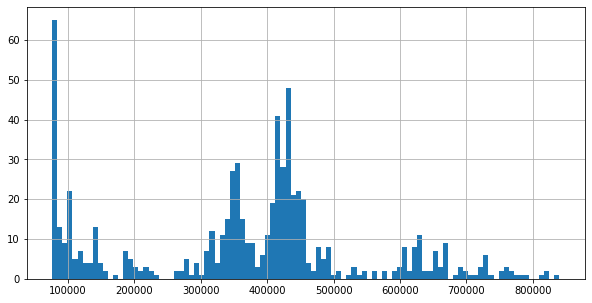

In [24]:
hannam810_df['거래금액(만원)'].hist(bins=100, figsize=(10,5))

In [25]:
hannamdong_df = apart_trade_df[apart_trade_df['시군구'] == '서울특별시 용산구 한남동']
hannamdong_df.shape

(2675, 12)

In [26]:
hannamdong_df.head()

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명
61999,서울특별시 용산구 한남동,726-74,726,74,남산맨션,89.45,201301,24,55000,15,1972,소월로 377
62000,서울특별시 용산구 한남동,726-74,726,74,남산맨션,124.50,201303,22,70500,13,1972,소월로 377
62001,서울특별시 용산구 한남동,726-74,726,74,남산맨션,124.50,201304,5,55000,4,1972,소월로 377
62002,서울특별시 용산구 한남동,726-74,726,74,남산맨션,147.84,201306,3,75000,11,1972,소월로 377
62003,서울특별시 용산구 한남동,726-74,726,74,남산맨션,107.60,201306,8,54000,5,1972,소월로 377


In [27]:
hannamdong_df['거래금액(만원)'].describe()

count      2675.000000
mean     142045.837009
std      162998.323365
min        7000.000000
25%       42837.000000
50%       70000.000000
75%      145000.000000
max      840000.000000
Name: 거래금액(만원), dtype: float64

<AxesSubplot:>

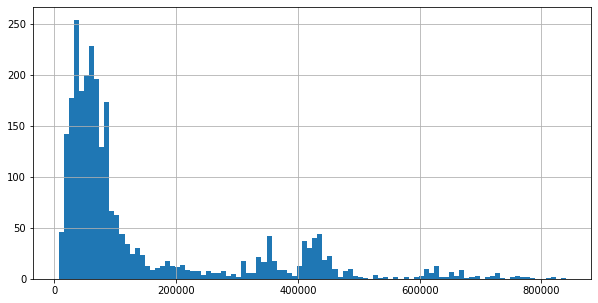

In [28]:
hannamdong_df['거래금액(만원)'].hist(bins=100, figsize=(10,5))

#### 조사 결과: 그냥 비싼 동네 정상적인 집값인 것으로 보임.

#### min: 보증금도 아닌 거래 금액이 350인 것은 너무 적어 보임. 이에 조사함

In [29]:
min_df = apart_trade_df[apart_trade_df['거래금액(만원)'] == 350]
print(min_df.shape)
min_df.head()

(1, 12)


,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명
945045,서울특별시 양천구 신월동,128,128,0,태헌(신월프라자),56.97,201005,25,350,7,1999,곰달래로5길 17


In [30]:
taehun_df = apart_trade_df[apart_trade_df['단지명'] == '태헌(신월프라자)']
print(taehun_df.shape)

(91, 12)


In [31]:
taehun_df

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명
57087,서울특별시 양천구 신월동,128,128,0,태헌(신월프라자),56.97,201301,15,16350,8,1999,곰달래로5길 17
57088,서울특별시 양천구 신월동,128,128,0,태헌(신월프라자),56.97,201302,21,16400,6,1999,곰달래로5길 17
57089,서울특별시 양천구 신월동,128,128,0,태헌(신월프라자),56.97,201303,30,14800,4,1999,곰달래로5길 17
57090,서울특별시 양천구 신월동,128,128,0,태헌(신월프라자),56.97,201304,4,17000,7,1999,곰달래로5길 17
57091,서울특별시 양천구 신월동,128,128,0,태헌(신월프라자),56.97,201311,25,16550,9,1999,곰달래로5길 17
57092,서울특별시 양천구 신월동,128,128,0,태헌(신월프라자),56.97,201312,7,16200,4,1999,곰달래로5길 17
57093,서울특별시 양천구 신월동,128,128,0,태헌(신월프라자),56.97,201312,10,15800,10,1999,곰달래로5길 17
139260,서울특별시 양천구 신월동,128,128,0,태헌(신월프라자),56.97,201404,10,14000,5,1999,곰달래로5길 17
139261,서울특별시 양천구 신월동,128,128,0,태헌(신월프라자),56.97,201404,10,16980,4,1999,곰달래로5길 17
139262,서울특별시 양천구 신월동,128,128,0,태헌(신월프라자),56.97,201405,8,16100,9,1999,곰달래로5길 17


In [32]:
taehun_df['거래금액(만원)'].describe()

count       91.000000
mean     15752.747253
std       4284.205635
min        350.000000
25%      13450.000000
50%      16300.000000
75%      18250.000000
max      22500.000000
Name: 거래금액(만원), dtype: float64

<AxesSubplot:>

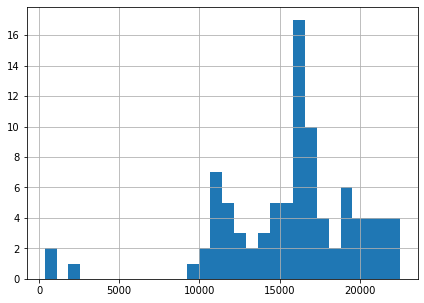

In [33]:
taehun_df['거래금액(만원)'].hist(bins=30, figsize=(7,5))

#### 조사 결과, 분명하게 outlier 들임. 제거하기로 결정함.

In [34]:
# Tukey의 기법을 사용하여 이상치 (outlier) 검색 후 제거 (거래금액)

def find_and_remove_Tukey_outliers_price(df):
    df = df.copy()    
    
    '''df['year'] = df['계약년월'].astype('str').str[:4]
    
    df['temp_full_addr'] = df['시군구'] # + df['본번'].astype('str') + df['단지명'] # + df['four_years']
    
    idx_list = []
    for addr in tqdm(df['temp_full_addr'].unique(), position=0):
        addr_df = df[df['temp_full_addr'] == addr]
        addr_df['target_transformed'] = quantile_transform(addr_df[['거래금액(만원)']], output_distribution='normal', n_quantiles=addr_df.shape[0])
        
        q1 = addr_df['target_transformed'].quantile(0.25)
        q3 = addr_df['target_transformed'].quantile(0.75)
        iqr = q3 - q1
        outlier_step = 1.5 * iqr
        
        outlier_df = addr_df[(addr_df['target_transformed'] < q1 - outlier_step)]
        
        for v in outlier_df.index:
            idx_list.append(v)
    '''
    
    df['target_transformed'] = quantile_transform(df[['거래금액(만원)']], output_distribution='normal', random_state=42)
        
    q1 = df['target_transformed'].quantile(0.25)
    q3 = df['target_transformed'].quantile(0.75)
    iqr = q3 - q1
    outlier_step = 1.5 * iqr

    outlier_df = df[(df['target_transformed'] < q1 - outlier_step)]
    
    
    print('{}개의 이상치를 찾아서 제거했습니다.'.format(outlier_df.shape[0]))
    
    df.drop(outlier_df.index, inplace=True)
    df.drop(columns=['target_transformed'], inplace=True)
    df = df.reset_index(drop=True)
    
    return df

In [36]:
apart_trade_df = find_and_remove_Tukey_outliers_price(apart_trade_df)
apart_trade_df.shape

3408개의 이상치를 찾아서 제거했습니다.


(1164784, 12)

#### 거래금액/전용면적 비율 조사

In [37]:
def show_price_to_area_ratio(df):
    df = df.copy()
    
    df['가격/면적'] = df['거래금액(만원)'] / df['전용면적(㎡)']
    
    display(df['가격/면적'].describe())
    display(df['가격/면적'].hist(bins=100))
    
    return df

In [57]:
def price_per_area_and_year_month(df):
    df = df.copy()
    
    df['가격/면적'] = df['거래금액(만원)'] / df['전용면적(㎡)']
    df['year'] = pd.to_numeric(df['계약년월'].astype('str').str[:4])
    df['month'] = pd.to_numeric(df['계약년월'].astype('str').str[4:])
    
    return df    

In [95]:
apart_trade_df = price_per_area_and_year_month(apart_trade_df)

In [96]:
apart_trade_df.head()

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적,year,month
0,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),77.75,201309,8,57000,2,1988,언주로 103,733.118971,2013,9
1,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),77.75,201312,16,57000,2,1988,언주로 103,733.118971,2013,12
2,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,67.28,201302,11,55000,5,1987,언주로 3,817.479191,2013,2
3,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,67.28,201302,22,58250,4,1987,언주로 3,865.784780,2013,2
4,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,67.28,201305,10,60000,5,1987,언주로 3,891.795482,2013,5


count    1.164784e+06
mean     6.693071e+02
std      3.814294e+02
min      5.575810e+01
25%      4.237288e+02
50%      5.580061e+02
75%      7.998177e+02
max      8.670964e+03
Name: 가격/면적, dtype: float64

<AxesSubplot:>

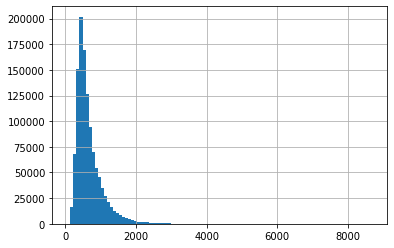

In [38]:
prac_df = show_price_to_area_ratio(apart_trade_df)

#### 가격/면적 최소치 조사

In [39]:
min_df = prac_df[prac_df['가격/면적'] == prac_df['가격/면적'].min()]
min_df.shape

(1, 13)

In [40]:
min_df

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적
672310,서울특별시 서초구 반포동,73-10,73,10,상지리츠빌(73-10),233.15,200609,22,13000,6,2001,사평대로28길 62,55.758096


In [41]:
min_danji_df = prac_df[prac_df['단지명'] == min_df['단지명'].iloc[0]]
min_danji_df.shape

(12, 13)

In [42]:
min_danji_df

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적
119880,서울특별시 서초구 반포동,73-10,73,10,상지리츠빌(73-10),183.27,201404,30,130000,1,2001,사평대로28길 62,709.335952
221059,서울특별시 서초구 반포동,73-10,73,10,상지리츠빌(73-10),180.39,201604,12,131000,3,2001,사평대로28길 62,726.204335
221060,서울특별시 서초구 반포동,73-10,73,10,상지리츠빌(73-10),180.39,201608,10,127000,1,2001,사평대로28길 62,704.030157
327217,서울특별시 서초구 반포동,73-10,73,10,상지리츠빌(73-10),180.39,201705,3,140000,4,2001,사평대로28길 62,776.096236
327218,서울특별시 서초구 반포동,73-10,73,10,상지리츠빌(73-10),233.15,201712,18,165000,6,2001,사평대로28길 62,707.698906
570302,서울특별시 서초구 반포동,73-10,73,10,상지리츠빌(73-10),180.39,202006,11,175000,3,2001,사평대로28길 62,970.120295
672308,서울특별시 서초구 반포동,73-10,73,10,상지리츠빌(73-10),180.39,200601,13,89800,4,2001,사평대로28길 62,497.810300
672309,서울특별시 서초구 반포동,73-10,73,10,상지리츠빌(73-10),183.27,200601,19,94000,1,2001,사평대로28길 62,512.904458
672310,서울특별시 서초구 반포동,73-10,73,10,상지리츠빌(73-10),233.15,200609,22,13000,6,2001,사평대로28길 62,55.758096
810194,서울특별시 서초구 반포동,73-10,73,10,상지리츠빌(73-10),180.39,200806,19,110000,1,2001,사평대로28길 62,609.789900


#### 조사 결과, 분명한 outlier 들임. 찾아서 제거하기로 결정.

In [97]:
# Tukey의 기법을 사용하여 이상치 (outlier) 검색 후 제거 (가격/면적)

def find_and_remove_Tukey_outliers_price_per_area(df):
    df = df.copy()
    
    df['가격/면적'] = df['거래금액(만원)'] / df['전용면적(㎡)']
    
    df['temp_full_addr'] = df['시군구'] + df['단지명']# + df['본번'].astype('str') + df['단지명']
    
    df['year'] = pd.to_numeric(df['계약년월'].astype('str').str[:4])
    
    idx_list = []
    for addr in tqdm(df['temp_full_addr'].unique(), position=0):
        addr_df = df[df['temp_full_addr'] == addr]
        addr_df['target_transformed'] = quantile_transform(addr_df[['가격/면적']], output_distribution='normal',
                                                           n_quantiles=addr_df.shape[0])
        
        q1 = addr_df['target_transformed'].quantile(0.25)
        q3 = addr_df['target_transformed'].quantile(0.75)
        iqr = q3 - q1
        outlier_step = 1.5 * iqr
        
        outlier_df = addr_df[(addr_df['target_transformed'] < q1 - outlier_step)|(addr_df['target_transformed'] > q3 + outlier_step)]
        
        for v in outlier_df.index:
            idx_list.append(v)    
    
    print('{}개의 이상치를 찾아서 제거했습니다.'.format(len(idx_list)))
    
    df.drop(idx_list, inplace=True)
    df.drop(columns=['temp_full_addr'])
    df.reset_index(drop=True, inplace=True)
    
    '''df['target_transformed'] = quantile_transform(df[['가격/면적']], output_distribution='normal', random_state=42)
        
    q1 = df['target_transformed'].quantile(0.25)
    q3 = df['target_transformed'].quantile(0.75)
    iqr = q3 - q1
    outlier_step = 1.5 * iqr

    outlier_df = df[(df['target_transformed'] < q1 - outlier_step) | (df['target_transformed'] > q3 + outlier_step)]
    
    
    print('{}개의 이상치를 찾아서 제거했습니다.'.format(outlier_df.shape[0]))
    
    df.drop(outlier_df.index, inplace=True)
    df.drop(columns=['target_transformed'], inplace=True)
    df = df.reset_index(drop=True)'''
    
    return df

In [98]:
prac_df = find_and_remove_Tukey_outliers_price_per_area(apart_trade_df)
prac_df.shape

7804개의 이상치를 찾아서 제거했습니다.


(1156980, 15)

In [99]:
prac_df['가격/면적'].describe()

count    1.156980e+06
mean     6.630881e+02
std      3.551518e+02
min      1.912752e+02
25%      4.243782e+02
50%      5.580424e+02
75%      7.969078e+02
max      2.581227e+03
Name: 가격/면적, dtype: float64

<AxesSubplot:>

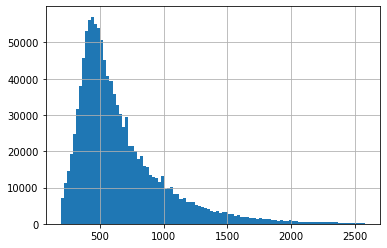

In [100]:
prac_df['가격/면적'].hist(bins=100)

#### 가격/면적 이상치 제거 후 최소치 조사

In [101]:
min_df = prac_df[prac_df['가격/면적'] == prac_df['가격/면적'].min()]
min_df.shape

(1, 15)

In [102]:
min_df

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적,year,month
707350,서울특별시 중랑구 신내동,487,487,0,라이프미성,59.6,200608,4,11400,4,1992,용마산로129나길 101,191.275168,2006,8


In [103]:
min_danji_df = prac_df[(prac_df['시군구'] == min_df['시군구'].iloc[0]) &(prac_df['단지명'] == min_df['단지명'].iloc[0])]
min_danji_df.shape

(240, 15)

In [104]:
min_danji_df

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적,year,month
67330,서울특별시 중랑구 신내동,487,487,0,라이프미성,76.16,201302,23,20300,7,1992,용마산로129나길 101,266.544118,2013,2
67331,서울특별시 중랑구 신내동,487,487,0,라이프미성,82.30,201304,21,24800,11,1992,용마산로129나길 101,301.336574,2013,4
67332,서울특별시 중랑구 신내동,487,487,0,라이프미성,59.23,201305,27,18000,9,1992,용마산로129나길 101,303.900051,2013,5
67333,서울특별시 중랑구 신내동,487,487,0,라이프미성,70.16,201306,3,27000,6,1992,용마산로129나길 101,384.834664,2013,6
67334,서울특별시 중랑구 신내동,487,487,0,라이프미성,59.60,201308,20,18500,2,1992,용마산로129나길 101,310.402685,2013,8
67335,서울특별시 중랑구 신내동,487,487,0,라이프미성,76.60,201308,21,20500,1,1992,용마산로129나길 101,267.624021,2013,8
152221,서울특별시 중랑구 신내동,487,487,0,라이프미성,59.60,201401,25,17800,11,1992,용마산로129나길 101,298.657718,2014,1
152222,서울특별시 중랑구 신내동,487,487,0,라이프미성,59.60,201402,8,17900,2,1992,용마산로129나길 101,300.335570,2014,2
152223,서울특별시 중랑구 신내동,487,487,0,라이프미성,59.60,201402,14,18500,8,1992,용마산로129나길 101,310.402685,2014,2
152224,서울특별시 중랑구 신내동,487,487,0,라이프미성,70.16,201402,17,21800,7,1992,용마산로129나길 101,310.718358,2014,2


#### 가격/면적 이상치 제거 후 최소치 조사 결과: 적당한 가격임

#### 이상치 제거 후 가격/면적 최대치 조사

In [51]:
max_df = prac_df[prac_df['가격/면적'] == prac_df['가격/면적'].max()]
max_df.shape

(1, 15)

In [52]:
max_df

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적,temp_full_addr,year
447023,서울특별시 강남구 개포동,141,141,0,개포주공 1단지,50.38,201911,4,270000,3,1982,개포로 310,5359.269551,서울특별시 강남구 개포동개포주공 1단지,2019


In [53]:
max_danji_df = prac_df[(prac_df['시군구'] == max_df['시군구'].iloc[0])&(prac_df['단지명'] == max_df['단지명'].iloc[0])&
                       (prac_df['year'] == max_df['year'].iloc[0])]
max_danji_df.shape

(186, 15)

In [54]:
max_danji_df

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적,temp_full_addr,year
446860,서울특별시 강남구 개포동,141,141,0,개포주공 1단지,50.64,201902,8,162000,2,1982,개포로 310,3199.052133,서울특별시 강남구 개포동개포주공 1단지,2019
446861,서울특별시 강남구 개포동,141,141,0,개포주공 1단지,58.08,201903,9,185000,4,1982,개포로 310,3185.261708,서울특별시 강남구 개포동개포주공 1단지,2019
446862,서울특별시 강남구 개포동,141,141,0,개포주공 1단지,50.38,201903,12,163000,2,1982,개포로 310,3235.410877,서울특별시 강남구 개포동개포주공 1단지,2019
446863,서울특별시 강남구 개포동,141,141,0,개포주공 1단지,42.55,201903,13,145000,3,1982,개포로 310,3407.755582,서울특별시 강남구 개포동개포주공 1단지,2019
446864,서울특별시 강남구 개포동,141,141,0,개포주공 1단지,35.87,201903,16,140000,2,1982,개포로 310,3902.982994,서울특별시 강남구 개포동개포주공 1단지,2019
446865,서울특별시 강남구 개포동,141,141,0,개포주공 1단지,50.38,201903,20,180000,3,1982,개포로 310,3572.846368,서울특별시 강남구 개포동개포주공 1단지,2019
446866,서울특별시 강남구 개포동,141,141,0,개포주공 1단지,50.64,201903,30,168000,1,1982,개포로 310,3317.535545,서울특별시 강남구 개포동개포주공 1단지,2019
446867,서울특별시 강남구 개포동,141,141,0,개포주공 1단지,49.56,201903,31,190000,2,1982,선릉로 7,3833.736885,서울특별시 강남구 개포동개포주공 1단지,2019
446868,서울특별시 강남구 개포동,141,141,0,개포주공 1단지,42.55,201904,7,150000,2,1982,개포로 310,3525.264395,서울특별시 강남구 개포동개포주공 1단지,2019
446869,서울특별시 강남구 개포동,141,141,0,개포주공 1단지,42.55,201904,11,149000,2,1982,개포로 310,3501.762632,서울특별시 강남구 개포동개포주공 1단지,2019


In [55]:
max_danji_df['가격/면적'].describe()

count     186.000000
mean     4121.823462
std       498.897773
min      3133.608815
25%      3811.216430
50%      4141.444713
75%      4421.484852
max      5359.269551
Name: 가격/면적, dtype: float64

#### 이상치 제거 후 가격/면적 최대치 조사 결과: 이상치 아님

In [56]:
prac_df['거래금액(만원)'].describe()

count    1.142798e+06
mean     5.241672e+04
std      3.989393e+04
min      7.940000e+03
25%      2.850000e+04
50%      4.150000e+04
75%      6.300000e+04
max      8.400000e+05
Name: 거래금액(만원), dtype: float64

### 연립주택

In [58]:
multiplex_trade_df = price_per_area_and_year_month(multiplex_trade_df)
multiplex_trade_df.shape

(662345, 16)

In [59]:
multiplex_trade_df.head()

,시군구,번지,본번,부번,건물명,전용면적(㎡),대지권면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적,year,month
0,서울특별시 강남구 개포동,1172-2,1172,2,(1172-2),42.15,24.67,201304,26,25000,3,2012,논현로6길 22-6,593.119810,2013,4
1,서울특별시 강남구 개포동,1172-2,1172,2,(1172-2),42.15,24.67,201306,4,25000,3,2012,논현로6길 22-6,593.119810,2013,6
2,서울특별시 강남구 개포동,1172-2,1172,2,(1172-2),42.15,24.67,201310,25,24500,2,2012,논현로6길 22-6,581.257414,2013,10
3,서울특별시 강남구 개포동,1216-4,1216,4,(1216-4),37.18,23.86,201302,13,27800,5,2012,개포로26길 16,747.713825,2013,2
4,서울특별시 강남구 개포동,1216-4,1216,4,(1216-4),35.87,23.02,201304,26,26500,3,2012,개포로26길 16,738.778924,2013,4


In [60]:
multiplex_trade_df['거래금액(만원)'].describe()

count    6.623450e+05
mean     2.149889e+04
std      1.661327e+04
min      3.500000e+02
25%      1.325000e+04
50%      1.870000e+04
75%      2.525000e+04
max      1.207550e+06
Name: 거래금액(만원), dtype: float64

<AxesSubplot:>

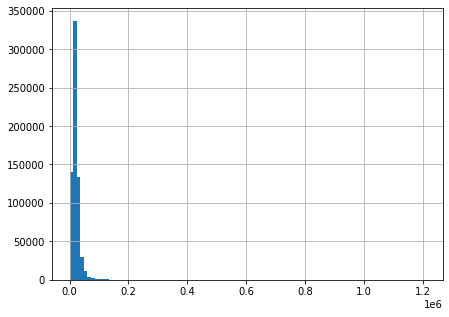

In [61]:
multiplex_trade_df['거래금액(만원)'].hist(bins=100, figsize=(7,5))

#### 연립주택 거래금액 최소값 조사

In [62]:
def show_min_df(df):
    df = df.copy()
    
    min_df = df[df['거래금액(만원)'] == df['거래금액(만원)'].min()]
    display(min_df)
    
    min_danji_df = df[(df['시군구'] == min_df['시군구'].iloc[0]) & (df['본번'] == min_df['본번'].iloc[0])]
    print(min_danji_df.shape)
    display(min_danji_df)

In [63]:
show_min_df(multiplex_trade_df)

,시군구,번지,본번,부번,건물명,전용면적(㎡),대지권면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적,year,month
117411,서울특별시 중랑구 중화동,306-12,306,12,(306-12),43.97,32.93,201512,22,350,1,1975,봉화산로15길 25,7.959973,2015,12


(27, 16)


,시군구,번지,본번,부번,건물명,전용면적(㎡),대지권면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적,year,month
117410,서울특별시 중랑구 중화동,306-12,306,12,(306-12),44.00,32.93,201506,19,9000,2,1975,봉화산로15길 25,204.545455,2015,6
117411,서울특별시 중랑구 중화동,306-12,306,12,(306-12),43.97,32.93,201512,22,350,1,1975,봉화산로15길 25,7.959973,2015,12
117412,서울특별시 중랑구 중화동,306-13,306,13,(306-13),43.97,30.95,201506,4,10900,1,1975,봉화산로15길 23,247.896293,2015,6
174474,서울특별시 중랑구 중화동,306-12,306,12,(306-12),43.97,32.93,201601,14,5000,1,1975,봉화산로15길 25,113.713896,2016,1
174699,서울특별시 중랑구 중화동,306-16,306,16,양지연립,73.91,82.64,201605,16,32500,1,1978,중랑역로 100-5,439.723989,2016,5
225452,서울특별시 중랑구 중화동,306-11,306,11,우승정원빌리지,29.96,20.09,201709,4,20700,4,2017,봉화산로15길 25,690.921228,2017,9
225453,서울특별시 중랑구 중화동,306-11,306,11,우승정원빌리지,47.11,30.62,201709,12,28000,2,2017,봉화산로15길 25,594.353640,2017,9
273343,서울특별시 중랑구 중화동,306-11,306,11,우승정원빌리지,29.49,20.09,201802,2,16300,3,2017,봉화산로15길 25,552.729739,2018,2
273344,서울특별시 중랑구 중화동,306-11,306,11,우승정원빌리지,29.49,20.09,201802,19,15500,2,2017,봉화산로15길 25,525.601899,2018,2
273345,서울특별시 중랑구 중화동,306-11,306,11,우승정원빌리지,47.11,30.62,201803,27,28300,2,2017,봉화산로15길 25,600.721715,2018,3


In [90]:
def find_and_remove_multiplex_Tukey_outliers_price_per_area(df):
    df = df.copy()
    
    df['target_transformed'] = quantile_transform(df[['가격/면적']], output_distribution='normal', random_state=42)
    
    q1 = df['target_transformed'].quantile(0.25)
    q3 = df['target_transformed'].quantile(0.75)
    iqr = q3 - q1
    outlier_step = 1.5 * iqr

    outlier_df = df[(df['target_transformed'] < q1 - outlier_step) | (df['target_transformed'] > q3 + outlier_step)]
    
    
    print('{}개의 이상치를 찾아서 제거했습니다.'.format(outlier_df.shape[0]))
    
    df.drop(outlier_df.index, inplace=True)
    df.drop(columns=['target_transformed'], inplace=True)
    df = df.reset_index(drop=True)
    
    return df

In [91]:
prac_df = find_and_remove_multiplex_Tukey_outliers_price_per_area(multiplex_trade_df)
prac_df.shape

4240개의 이상치를 찾아서 제거했습니다.


(658105, 16)

In [105]:
prac_df['가격/면적'].describe()

count    1.156980e+06
mean     6.630881e+02
std      3.551518e+02
min      1.912752e+02
25%      4.243782e+02
50%      5.580424e+02
75%      7.969078e+02
max      2.581227e+03
Name: 가격/면적, dtype: float64

In [106]:
min_df = prac_df[prac_df['가격/면적'] == prac_df['가격/면적'].min()]
min_df.shape

(1, 15)

In [107]:
min_df

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적,year,month
707350,서울특별시 중랑구 신내동,487,487,0,라이프미성,59.6,200608,4,11400,4,1992,용마산로129나길 101,191.275168,2006,8


In [108]:
min_building_df = prac_df[(prac_df2['시군구'] == min_df['시군구'].iloc[0])&(prac_df['건물명'] == min_df['건물명'].iloc[0])]
min_building_df.shape

KeyError: '건물명'

In [83]:
min_building_df

,시군구,번지,본번,부번,건물명,전용면적(㎡),대지권면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적,year,month
1921,서울특별시 강북구 미아동,258-580,258,580,우광빌라,39.56,26.67,201302,18,8000,2,1987,오패산로52사길 23,202.224469,2013,2
1922,서울특별시 강북구 미아동,258-58,258,58,우광빌라,36.58,24.50,201304,26,9300,1,1988,오패산로52자길 12,254.237288,2013,4
1923,서울특별시 강북구 미아동,258-664,258,664,우광빌라,36.58,24.67,201311,13,9000,-1,1988,오패산로52자길 10,246.036085,2013,11
31532,서울특별시 강북구 미아동,258-632,258,632,우광빌라,30.64,20.50,201403,25,4500,-1,1988,오패산로52사길 35,146.866841,2014,3
31533,서울특별시 강북구 미아동,258-59,258,59,우광빌라,39.03,26.17,201407,16,6000,-1,1988,오패산로52자길 8,153.727902,2014,7
31534,서울특별시 강북구 미아동,258-73,258,73,우광빌라,39.56,26.33,201412,20,8000,1,1988,오패산로52사길 17,202.224469,2014,12
67990,서울특별시 강북구 미아동,258-100,258,100,우광빌라,39.51,26.83,201501,20,9100,1,1988,오패산로52길 91,230.321438,2015,1
67991,서울특별시 강북구 미아동,258-57,258,57,우광빌라,41.45,28.38,201503,10,8400,2,1988,오패산로52자길 14,202.653800,2015,3
67992,서울특별시 강북구 미아동,258-580,258,580,우광빌라,39.56,26.67,201504,6,7900,2,1987,오패산로52사길 23,199.696663,2015,4
67993,서울특별시 강북구 미아동,258-632,258,632,우광빌라,30.64,20.50,201511,12,7000,1,1988,오패산로52사길 35,228.459530,2015,11


#### 조사 결과: 이상치 아님